# Build Model SureVenir

SureVenir ....




## Imports Library

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam


## Prepare the Dataset

In [3]:
# Define the path of dataset directory
dataset_path  = "./dataset-ml"

In [4]:
# Parameter untuk preprocessing
img_height, img_width = 150, 150  


def load_and_preprocess_data(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  
    class_labels = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name, label in class_labels.items():
        class_folder = os.path.join(directory, class_name)

        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            try:
                
                image = Image.open(file_path).convert("RGB")
                image = image.resize((img_width, img_height))
                image_array = np.array(image, dtype=np.float32) / 255.0  # Normalisasi
                images.append(image_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")

    
    num_classes = len(class_names)
    labels_one_hot = np.eye(num_classes)[labels]  

    return np.array(images), labels_one_hot, class_labels


images, labels_one_hot, class_labels = load_and_preprocess_data(dataset_path)


print(f"Total images: {len(images)}")
print(f"Shape of image data: {images.shape}")
print(f"Shape of label data: {labels_one_hot.shape}")
print(f"Class labels (numeric): {class_labels}")


Total images: 2136
Shape of image data: (2136, 150, 150, 3)
Shape of label data: (2136, 20)
Class labels (numeric): {'anting-kayu-bali': 0, 'anting-silver': 1, 'baju-barong': 2, 'baju-i-love-bali': 3, 'cincin-silver': 4, 'dream-catcher': 5, 'gantungan-kunci': 6, 'gelang-manik-bali': 7, 'gelang-tridatu': 8, 'hiasan-dinding': 9, 'jepit-rambut': 10, 'kain-pantai-bali': 11, 'keben-bali': 12, 'kipas-kayu-bali': 13, 'lilin-aromaterapi': 14, 'tas-anyaman': 15, 'tas-rajut': 16, 'tas-rotan': 17, 'tempat-lilin': 18, 'udeng': 19}


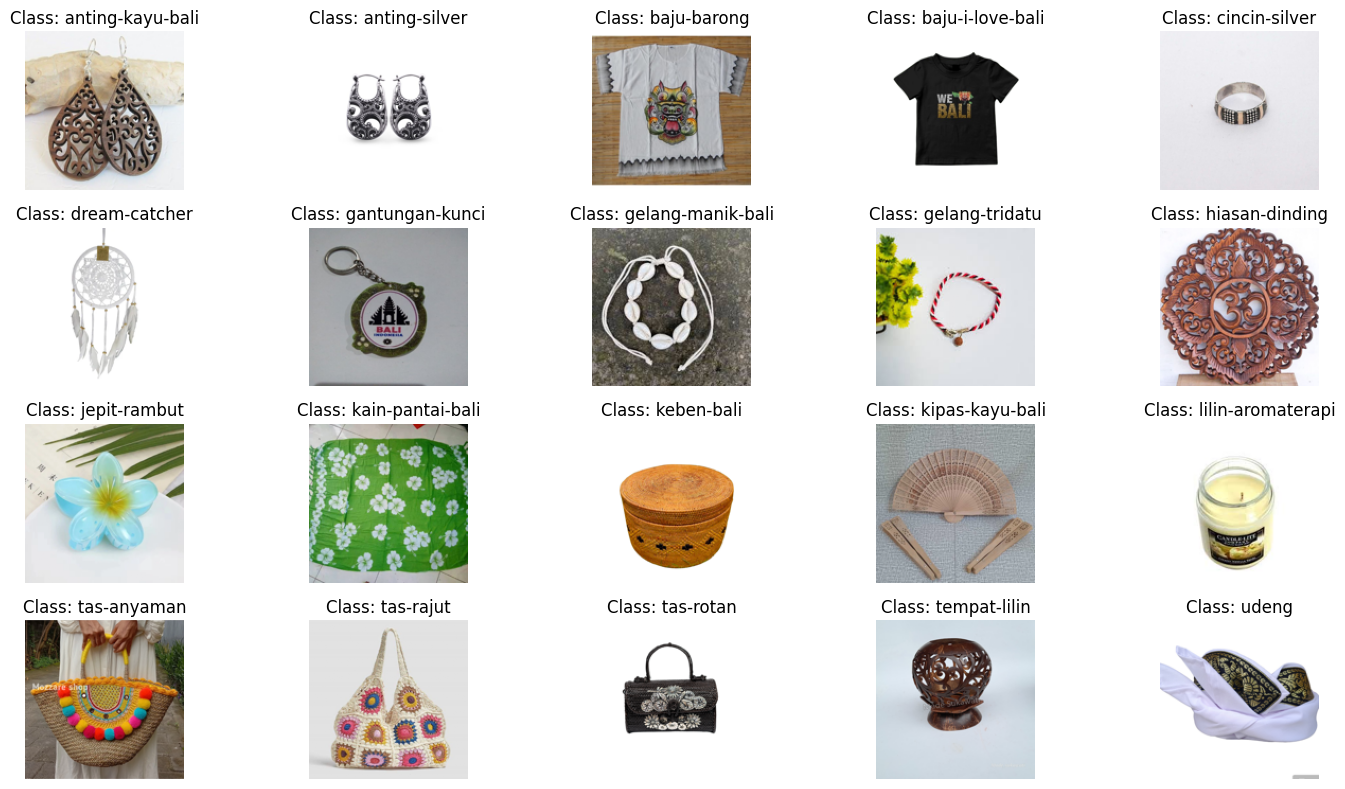

In [5]:
fig, axes = plt.subplots(4, 5, figsize=(15, 8))  
axes = axes.flatten()  


for idx, (class_name, class_label) in enumerate(class_labels.items()):
    if idx >= len(axes):  
        break
    
    class_indices = np.where(np.argmax(labels_one_hot, axis=1) == class_label)[0]
    if len(class_indices) == 0:
        continue
    
    img = images[class_indices[0]]
    axes[idx].imshow(img)
    axes[idx].set_title(f'Class: {class_name}')
    axes[idx].axis('off')  

plt.tight_layout()
plt.show()

SPLIT THE DATASET


In [6]:
def split_data(images, labels, class_labels, dataset_path, split_ratio=(0.80, 0.20)):
    
    if sum(split_ratio) != 1.0:
        raise ValueError("Split ratio harus bernilai 1.0 jika dijumlahkan.")
    
    
    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')

    
    for path in [train_path, test_path]:
        os.makedirs(path, exist_ok=True)
    
   
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=split_ratio[1], stratify=labels)
    
   
    def save_images(images, labels, folder_path):
        for idx, image in enumerate(images):
            image = (image * 255).astype(np.uint8)  
            label_index = np.argmax(labels[idx])  
            class_name = [name for name, value in class_labels.items() if value == label_index][0]
            class_folder = os.path.join(folder_path, class_name)
            os.makedirs(class_folder, exist_ok=True)
            image_path = os.path.join(class_folder, f"{idx}.jpg")
            Image.fromarray(image).save(image_path)
    
   
    save_images(train_images, train_labels, train_path)
    save_images(test_images, test_labels, test_path)

    print(f"Data berhasil dibagi ke dalam folder:\n- Train: {len(train_images)}\n- Test: {len(test_images)}")


split_data(images, labels_one_hot, class_labels, dataset_path)

Data berhasil dibagi ke dalam folder:
- Train: 1708
- Test: 428


DATA AUGMENTASI


In [7]:
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

training_datagen = ImageDataGenerator(
	rescale = 1./255,
    rotation_range=20, 
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50.0,
	shear_range=0.2,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(150,150),
	class_mode='categorical',
    batch_size=15
)

validation_generator = validation_datagen.flow_from_directory(
	test_dir,
	target_size=(150,150),
	class_mode='categorical',
    batch_size=15
)

print("Dataset telah siap untuk digunakan.")

Found 1708 images belonging to 20 classes.
Found 428 images belonging to 20 classes.
Dataset telah siap untuk digunakan.


## Build the Model

In [18]:
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(150, 150, 3))

base_model.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(20, activation='softmax')
])

# Print the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 20)                10260     
                                                                 
Total params: 2924116 (11.15 MB)
Trainable params: 666

In [19]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [20]:
epochs = 15

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=2
)
# Evaluasi model dengan dataset test
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/15
114/114 - 17s - loss: 2.2631 - accuracy: 0.3355 - val_loss: 1.1416 - val_accuracy: 0.7477 - 17s/epoch - 149ms/step
Epoch 2/15
114/114 - 23s - loss: 1.0905 - accuracy: 0.6920 - val_loss: 0.6445 - val_accuracy: 0.8341 - 23s/epoch - 202ms/step
Epoch 3/15
114/114 - 14s - loss: 0.7322 - accuracy: 0.7775 - val_loss: 0.4743 - val_accuracy: 0.8762 - 14s/epoch - 123ms/step
Epoch 4/15
114/114 - 12s - loss: 0.5767 - accuracy: 0.8337 - val_loss: 0.4046 - val_accuracy: 0.8832 - 12s/epoch - 109ms/step
Epoch 5/15
114/114 - 12s - loss: 0.4517 - accuracy: 0.8595 - val_loss: 0.3842 - val_accuracy: 0.8902 - 12s/epoch - 103ms/step
Epoch 6/15
114/114 - 12s - loss: 0.3757 - accuracy: 0.8917 - val_loss: 0.3178 - val_accuracy: 0.9065 - 12s/epoch - 108ms/step
Epoch 7/15
114/114 - 12s - loss: 0.2993 - accuracy: 0.9133 - val_loss: 0.2974 - val_accuracy: 0.9112 - 12s/epoch - 106ms/step
Epoch 8/15
114/114 - 13s - loss: 0.2632 - accuracy: 0.9233 - val_loss: 0.2857 - val_accuracy: 0.9159 - 13s/epoch - 115

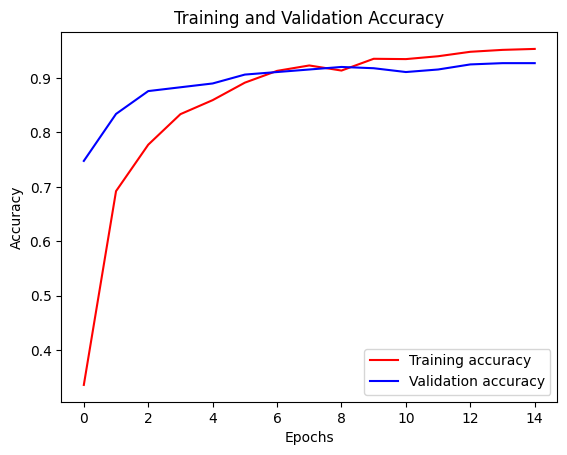

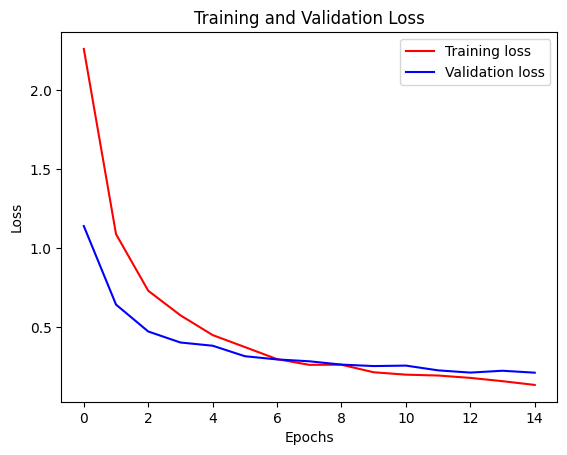

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

# Plot Akurasi Training dan Validation
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Loss Training dan Validation
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [62]:
model.save('model-surevenir.h5')

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
classes = {
    0: "anting-kayu-bali",
    1: "anting-silver",
    2: "baju-barong",
    3: "baju-i-love-bali",
    4: "cincin-silver",
    5: "dream-catcher",
    6: "gantungan-kunci",
    7: "gelang-manik-bali",
    8: "gelang-tridatu",
    9: "hiasan-dinding",
    10: "jepit-rambut",
    11: "kain-pantai-bali",
    12: "keben-bali",
    13: "kipas-kayu-bali",
    14: "lilin-aromaterapi",
    15: "tas-anyaman",
    16: "tas-rajut",
    17: "tas-rotan",
    18: "tempat-lilin",
    19: "udeng"
}

def predict_image(image_path):
    try:
        # Open image and convert to RGB
        image = Image.open(image_path).convert("RGB")  
        image = image.resize((150, 150))  # Resize image to the required input size
        image_array = tf.keras.utils.img_to_array(image) / 255.0  # Normalize the image
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        
        # Make prediction
        prediction = model.predict(image_array, verbose=0)[0]
        
        # Get predicted class and confidence level
        predicted_class = classes[np.argmax(prediction)]
        confidence = np.max(prediction) * 100
        return predicted_class, confidence
    except Exception as e:
        return f"Error: {e}", None

# Test with an image path
image_path = "predict4.jpg"
predicted_class, confidence = predict_image(image_path)

# Print results
if confidence is not None:
    print(f"\nPredicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
else:
    print(predicted_class)



Predicted Class: keben-bali
Confidence: 98.21%
